In [1]:
! pip install imbalanced-learn --quiet
! pip install deslib --quiet
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import NearMiss
from matplotlib import pyplot
from imblearn.over_sampling import RandomOverSampler
from deslib.des.knora_e import KNORAE
import numpy as np
from sklearn.datasets import make_classification
from deslib.des import METADES
from deslib.des import KNORAE
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import numpy as np

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.6f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.6f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:
def plot_class_distribution(X,y):
    matr = X.copy(deep=True)
    matr['carat_class'] = y

    plt.figure(figsize=(6, 6))
    fig = sns.catplot(x="carat_class", kind="count", data=matr)
    fig.set_axis_labels("Carat class", "Counts")
    plt.title("Carat class distribution")
    plt.show()

In [4]:
def preprocess(df):
    df['cut'] = df['cut'].astype('category')
    df['color'] = df['color'].astype('category')
    df['clarity'] = df['clarity'].astype('category')
    df['carat_class'] = df['carat_class'].astype('category')
    
    df.dropna(inplace=True)
    
    for column in df.columns:
        if (df[column].dtype != float):
            continue
            
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        P90 = df[column].quantile(0.90)
        df_out = df[df[column] > P90]
        df[column] = df[column].apply(lambda x: P90 if (x > P90) else x)
        df_out = df[df[column] > P90]
    
    #df['carat_class'] = df['carat_class'].map({'low':0, 'medium':1, 'high':2}).astype(float)
    df = pd.get_dummies(df, columns=['cut','color','clarity'])
    
    return df

<Figure size 432x432 with 0 Axes>

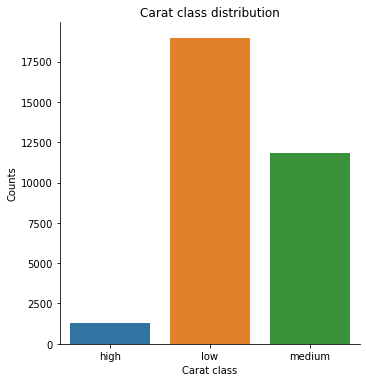

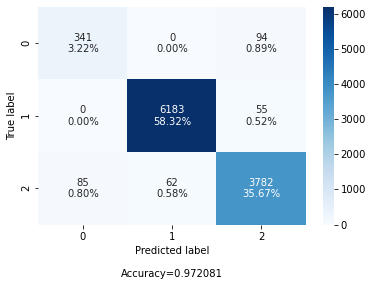

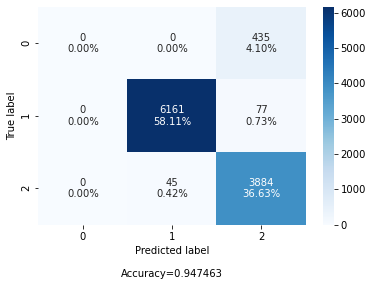

In [5]:
path_to_dataset = 'datasets/TRAIN_TO_SHARE.CSV'
dataset = pd.read_csv(path_to_dataset)
dataset = preprocess(dataset)

X=dataset.drop(columns=['carat_class'])
y=dataset['carat_class']

plot_class_distribution(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
make_confusion_matrix(conf_matrix)

clf = RandomForestClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
make_confusion_matrix(conf_matrix)

<Figure size 432x432 with 0 Axes>

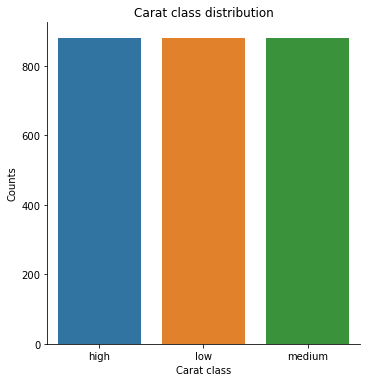

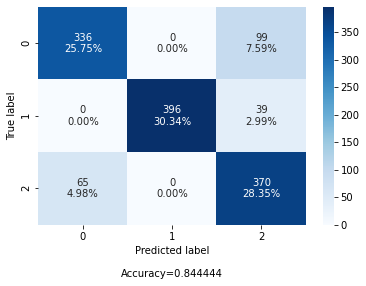

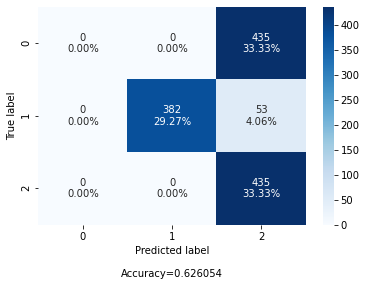

In [6]:
#undersampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X_sample, y_sample = undersample.fit_resample(X_train,y_train)
X_test, y_test = undersample.fit_resample(X_test,y_test)

plot_class_distribution(X_sample,y_sample)


clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
make_confusion_matrix(conf_matrix)

clf = RandomForestClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
make_confusion_matrix(conf_matrix)

<Figure size 432x432 with 0 Axes>

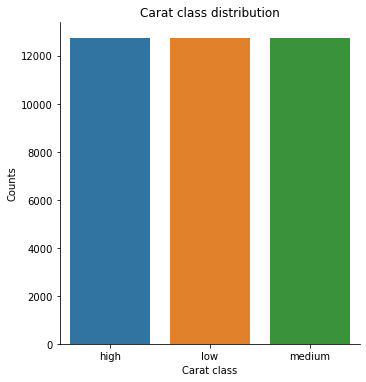

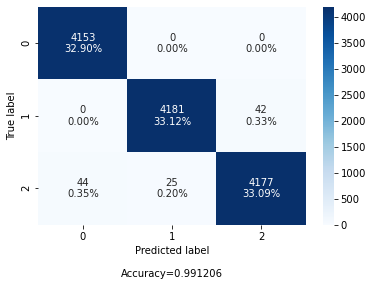

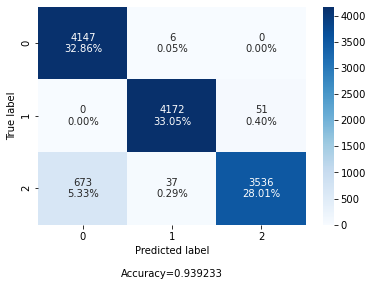

In [7]:
#oversampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


ros = RandomOverSampler(random_state=42)
X_sample, y_sample = ros.fit_resample(X_train,y_train)
X_test, y_test = ros.fit_resample(X_test,y_test)


plot_class_distribution(X_sample,y_sample)

X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.33, random_state=42)

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
make_confusion_matrix(conf_matrix)

clf = RandomForestClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
make_confusion_matrix(conf_matrix)

In [8]:
#stocking methods

<Figure size 432x432 with 0 Axes>

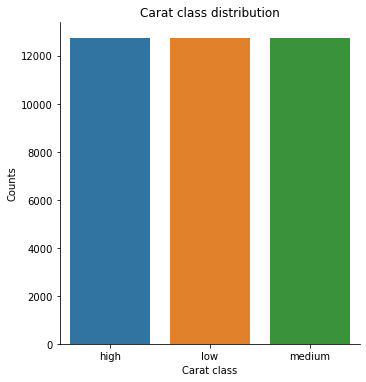

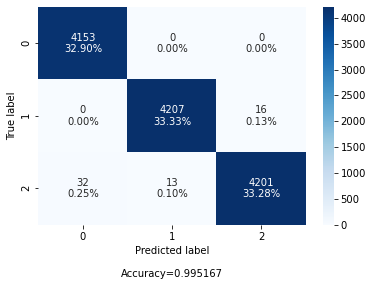

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


#scikit stacking classifier
ros = RandomOverSampler(random_state=42)
X_sample, y_sample = ros.fit_resample(X_train,y_train)
X_test, y_test = ros.fit_resample(X_test,y_test)


plot_class_distribution(X_sample,y_sample)


X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.33, random_state=42)


estimators = [
     ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('svr', make_pipeline(StandardScaler(),
                           LinearSVC(random_state=42)))
 ]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression() )
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
make_confusion_matrix(conf_matrix)

<Figure size 432x432 with 0 Axes>

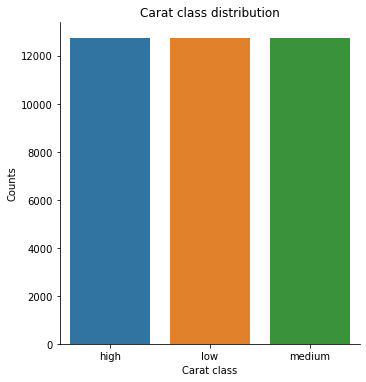

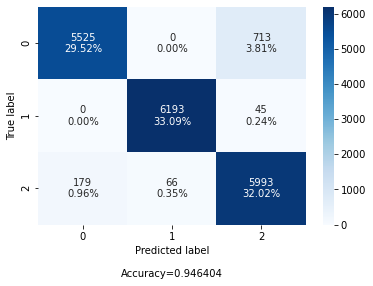

In [10]:
#stacking model - KNORA-Eliminate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ros = RandomOverSampler(random_state=42)
X_sample, y_sample = ros.fit_resample(X_train,y_train)
X_test, y_test = ros.fit_resample(X_test,y_test)


plot_class_distribution(X_sample,y_sample)

# Split the data into training and DSEL for DS techniques
X_train, X_dsel, y_train, y_dsel = train_test_split(X_sample, y_sample,test_size=0.5, random_state=42)


# Train a pool of 10 classifiers
pool_classifiers = RandomForestClassifier(n_estimators=10)
pool_classifiers.fit(X_train, y_train)

# Initialize the DES model
knorae = KNORAE(pool_classifiers)

# Preprocess the Dynamic Selection dataset (DSEL)
knorae.fit(X_dsel, y_dsel)

# Predict new examples:
y_pred = knorae.predict(X_test)


conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
make_confusion_matrix(conf_matrix)